# ABS Inflation multi-measure

In [1]:
"""ABS Inflation Multi-measure Analysis."""

'ABS Inflation Multi-measure Analysis.'

## Python set-up

In [2]:
"""Improved imports and type annotations."""
# Standard library imports
from collections.abc import Sequence
from io import StringIO
from typing import cast

# Third-party imports
import mgplot as mg
import pandas as pd

# Local imports
import sdmxabs as sa
from sdmxabs import MatchType as Mt

In [3]:
# Configuration constants
CHART_DIR = "./CHARTS/Inflation-sdmx/"
SHOW_CHARTS = True
RECENCY_QUARTERS = 12

# Chart styling constants
RBA_TARGET_BAND = {
    "ymin": 2,
    "ymax": 3,
    "color": "lightgrey",
    "alpha": 0.5,
    "label": "RBA Target Band",
    "zorder": -1
}

CHART_COLORS = ("blue", "orangered", "green", "purple", "darkorange", "navy")

# Data processing constants
TTY_INDEX_THRESHOLD = 50  # Use index growth when index is above this value

# Initialize chart directory
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

## Direct inflation indicators

### Get and manipulate the data

In [4]:
def create_selection_tables() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Create monthly and quarterly data selection tables."""
    # Monthly selections
    monthly_text = """
    flow_id, MEASURE, INDEX, TSEST, REGION, FREQ
    CPI_M,         3, 10001,    10,     50,    M
    CPI_M,         3, 999905,   10,     50,    M
    """
    monthly_selection = pd.read_csv(StringIO(monthly_text), dtype=str, skipinitialspace=True)

    # Quarterly selections
    quarterly_text = """
    flow_id, MEASURE, INDEX, TSEST, REGION, DATA_ITEM, SECTOR, FREQ
    CPI,           3, 10001,    10,     50,         -,      -,    Q
    CPI,           3, 999902,   20,     50,         -,      -,    Q
    CPI,           3, 999903,   20,     50,         -,      -,    Q
    ANA_EXP,     DCH,      -,   20,    AUS,       FCE,    PHS,    Q
    ANA_EXP, PCT_DCH,      -,   20,    AUS,       FCE,    PHS,    Q
    """
    quarterly_selection = pd.read_csv(StringIO(quarterly_text), dtype=str, skipinitialspace=True)

    return monthly_selection, quarterly_selection


def calculate_tty_growth(quarterly_data: pd.DataFrame) -> pd.DataFrame:
    """Calculate through-the-year (TTY) growth for HFCE data.

    Uses quarterly percentage change for early years and index for later years
    to avoid distortion in TTY growth calculations.

    """
    q_data = quarterly_data.copy()

    q_percent_col = "ANA_EXP.PCT_DCH.FCE.PHS.20.AUS.Q.PCT.0"
    q_index_col = "ANA_EXP.DCH.FCE.PHS.20.AUS.Q.IN.0"

    # Calculate TTY growth from index (for later years)
    tty_from_index = q_data[q_index_col].pct_change(4) * 100

    # Calculate TTY growth from quarterly growth (for early years)
    tty_from_quarterly = (
        ((q_data[q_percent_col] / 100) + 1)
        .rolling(4)
        .agg(lambda x: x.prod()) - 1
    ) * 100

    # Use index growth when index is above threshold, otherwise use quarterly growth
    tty_growth = tty_from_index.where(
        q_data[q_index_col].notna() & (q_data[q_index_col] > TTY_INDEX_THRESHOLD),
        other=tty_from_quarterly
    )

    # Replace index with TTY growth and drop percentage change column
    q_data[q_index_col] = tty_growth
    return q_data.drop(columns=[q_percent_col])


def create_readable_column_names(data: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:
    """Create human-readable column names from metadata."""
    # Fill missing INDEX values with DATA_ITEM + SECTOR info
    metadata["INDEX"] = metadata["INDEX"].where(
        metadata["INDEX"].notna(),
        other=metadata["DATA_ITEM"] + " " + metadata["SECTOR"] + " IPD"
    )

    # Create readable names
    renamer = {}
    for col in metadata.index:
        name = f"{metadata.loc[col, 'FREQ']} {metadata.loc[col, 'INDEX']} {metadata.loc[col, 'TSEST']}"
        renamer[col] = name

    return data.rename(columns=renamer)


def get_raw_indicators() -> tuple[pd.DataFrame, pd.DataFrame, Sequence[str], pd.Period]:
    """Extract and prepare the key inflation indicators from ABS SDMX data."""
    # Create selection tables
    monthly_selection, quarterly_selection = create_selection_tables()

    # Get list of data flows
    combined_selections = pd.concat([monthly_selection, quarterly_selection], axis=0, ignore_index=True)
    data_flows = list(combined_selections["flow_id"].unique())

    # Fetch data
    monthly_data, monthly_meta = sa.fetch_multi(monthly_selection, validate=True)
    quarterly_data, quarterly_meta = sa.fetch_multi(quarterly_selection, validate=False)

    # Calculate TTY growth for quarterly data
    quarterly_data = calculate_tty_growth(quarterly_data)

    # Convert quarterly to monthly periods (end of quarter)
    quarterly_data.index = cast("pd.PeriodIndex", quarterly_data.index).to_timestamp(how="end").to_period("M")

    # Get recent starting point
    recent_period = quarterly_data.index[-9]

    # Combine datasets
    combined_data = pd.concat([monthly_data, quarterly_data], axis=1).sort_index()
    combined_meta = pd.concat([monthly_meta, quarterly_meta], axis=0)

    # Create readable column names
    combined_data = create_readable_column_names(combined_data, combined_meta)

    return combined_data, combined_meta, data_flows, recent_period

### Plot the data

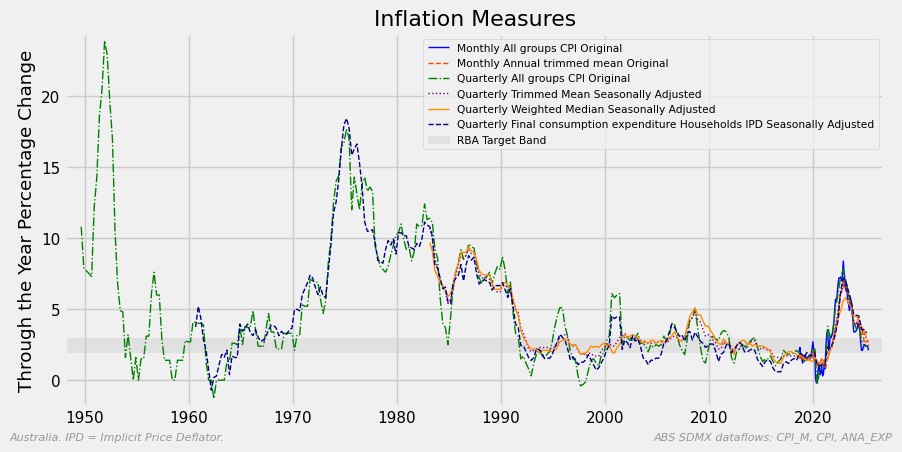

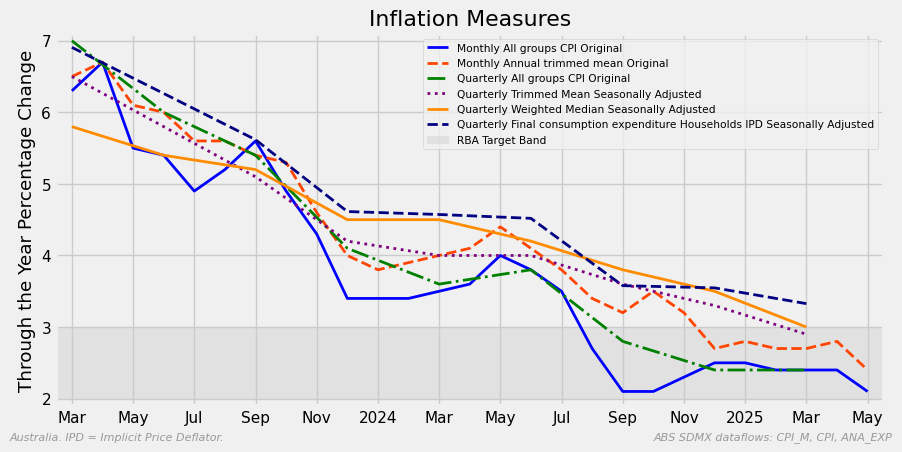

In [5]:
def plot_raw_indicators() -> None:
    """Plot the key inflation indicators from ABS SDMX data."""
    data, metadata, data_flows, recent_period = get_raw_indicators()

    mg.multi_start(
        data,
        starts=(0, recent_period),
        function=mg.line_plot_finalise,
        title="Inflation Measures",
        ylabel="Through the Year Percentage Change",
        axhspan=RBA_TARGET_BAND,
        legend={"loc": "best", "ncol": 1, "fontsize": "x-small"},
        color=CHART_COLORS,
        lfooter="Australia. IPD = Implicit Price Deflator.",
        rfooter=f"ABS SDMX dataflows: {', '.join(data_flows)}",
        show=SHOW_CHARTS,
    )


# Execute the plotting function
plot_raw_indicators()

## Upstream indicators of inflation
And testing the selection by pattern matchibng ...

### Select the data we want

In [6]:
def create_wpi_criteria() -> pd.DataFrame:
    """Create selection criteria for WPI (Wage Price Index) data."""
    criteria = [
        ("Australia", "REGION", Mt.EXACT),
        ("Percentage change from corresponding quarter of previous year", "MEASURE", Mt.EXACT),
        ("Total hourly rates of pay excluding bonuses", "INDEX", Mt.PARTIAL),
        ("Seasonal", "TSEST", Mt.PARTIAL),
        ("13-Industry aggregate", "INDUSTRY", Mt.EXACT),
        ("Private and Public", "SECTOR", Mt.EXACT),
    ]
    return sa.make_wanted("WPI", criteria)


def create_ppi_criteria() -> pd.DataFrame:
    """Create selection criteria for PPI_FD (Producer Price Index) data."""
    criteria = [
        ("Corresponding Quarter of Previous Year", "MEASURE", Mt.PARTIAL),
        ("total all industries", "INDEX", Mt.PARTIAL),
        ("Total (excl. exports)", "DESTINATION", Mt.PARTIAL),
        ("Quarter", "FREQ", Mt.PARTIAL),
    ]
    return sa.make_wanted("PPI_FD", criteria)


def build_selection_criteria() -> pd.DataFrame:
    """Build the selection criteria for the upstream inflation indicators."""
    wpi_selection = create_wpi_criteria()
    ppi_selection = create_ppi_criteria()

    return pd.concat([wpi_selection, ppi_selection])

### Plot the data

Missing dimensions for WPI: ['FREQ']
Missing dimensions for PPI_FD: ['SOURCE']


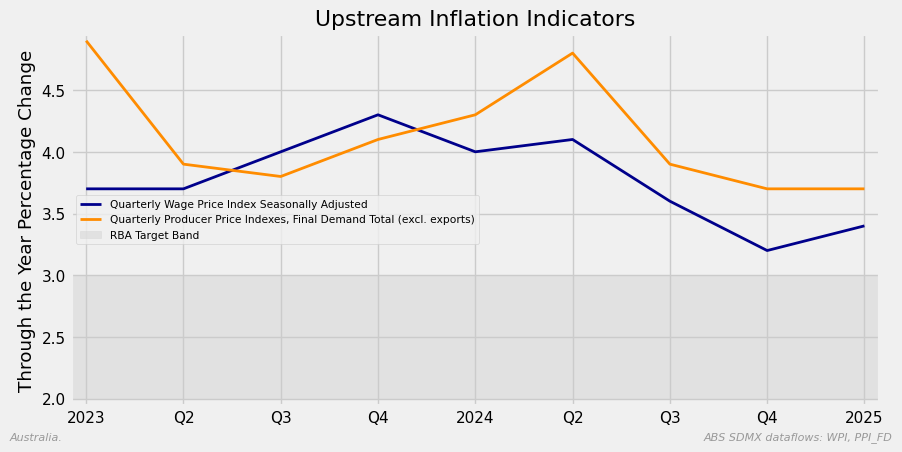

In [7]:
def create_upstream_column_names(data: pd.DataFrame, metadata: pd.DataFrame) -> pd.DataFrame:
    """Create human-readable column names for upstream indicators."""
    metadata_filled = metadata.fillna("")
    renamer = {}

    for col in data.columns:
        name = (
            f"{metadata_filled.loc[col, 'FREQ']} {metadata_filled.loc[col, 'DATAFLOW']} "
            f"{metadata_filled.loc[col, 'DESTINATION']} {metadata_filled.loc[col, 'TSEST']}"
        )
        renamer[col] = name.replace("  ", " ").strip()

    return data.rename(columns=renamer)


def plot_upstream_indicators() -> None:
    """Plot the upstream inflation indicators."""
    # Get selection criteria and fetch data
    selection_criteria = build_selection_criteria()
    data, metadata = sa.fetch_multi(selection_criteria, validate=True)

    # Create readable column names
    data = create_upstream_column_names(data, metadata)

    # Plot the data
    mg.line_plot_finalise(
        data,
        plot_from=-9,
        title="Upstream Inflation Indicators",
        ylabel="Through the Year Percentage Change",
        axhspan=RBA_TARGET_BAND,
        legend=True,
        lfooter="Australia. ",
        rfooter=f"ABS SDMX dataflows: {', '.join(selection_criteria.flow_id.unique())}",
        show=SHOW_CHARTS,
    )


# Execute the plotting function
plot_upstream_indicators()

## Compare Quarterly and Monthly Series (over recent)

Processing: All groups CPI
Missing dimensions for CPI_M: ['TSEST']


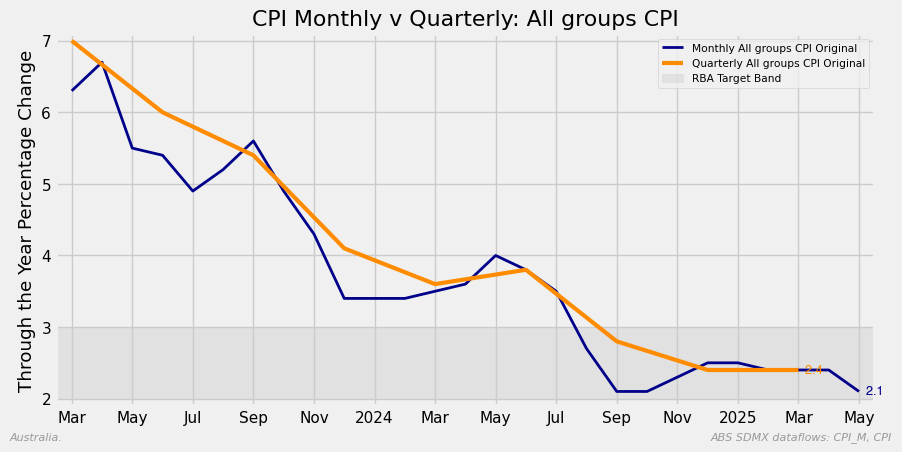

Processing: All groups CPI, seasonally adjusted
Missing dimensions for CPI_M: ['TSEST']


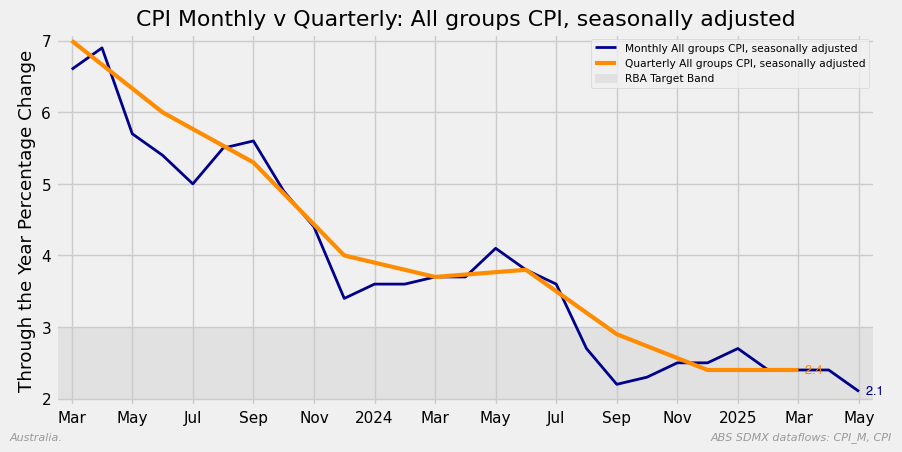

Processing: All groups, services component
Missing dimensions for CPI_M: ['TSEST']


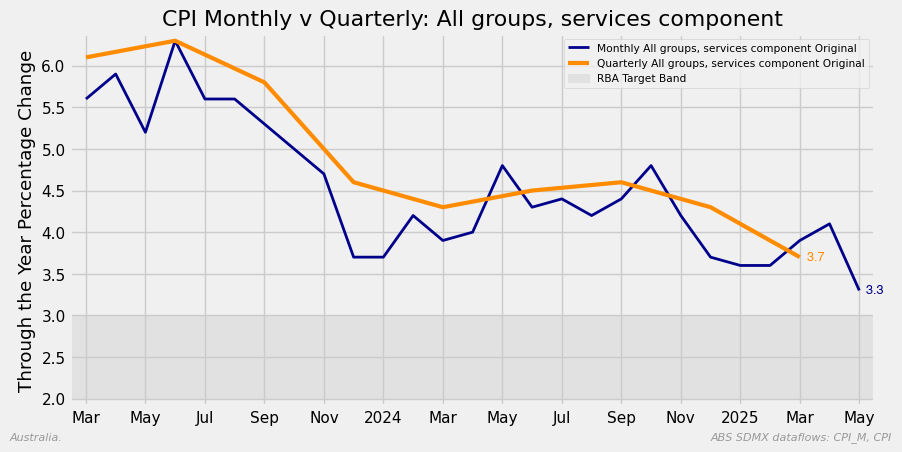

Processing: All groups, goods component
Missing dimensions for CPI_M: ['TSEST']


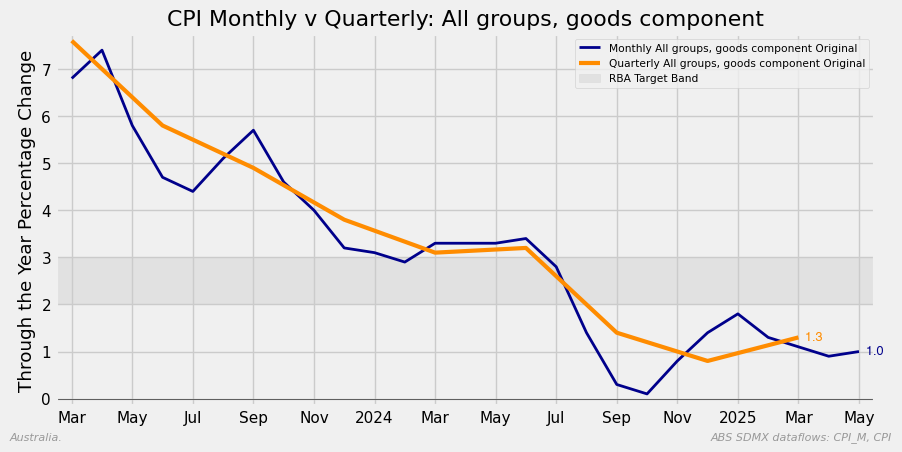

Processing: Trimmed Mean
Missing dimensions for CPI_M: ['TSEST']
Missing dimensions for CPI: ['TSEST']


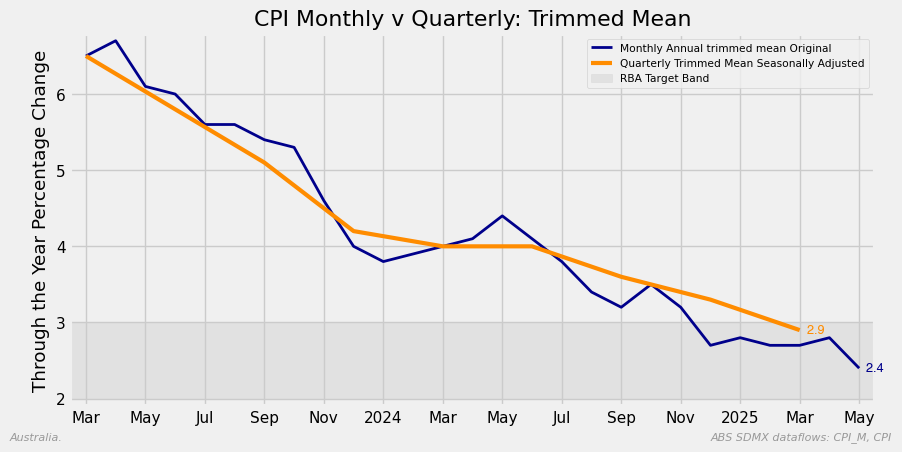

Processing: All groups CPI excluding 'volatile items'
Missing dimensions for CPI_M: ['TSEST']


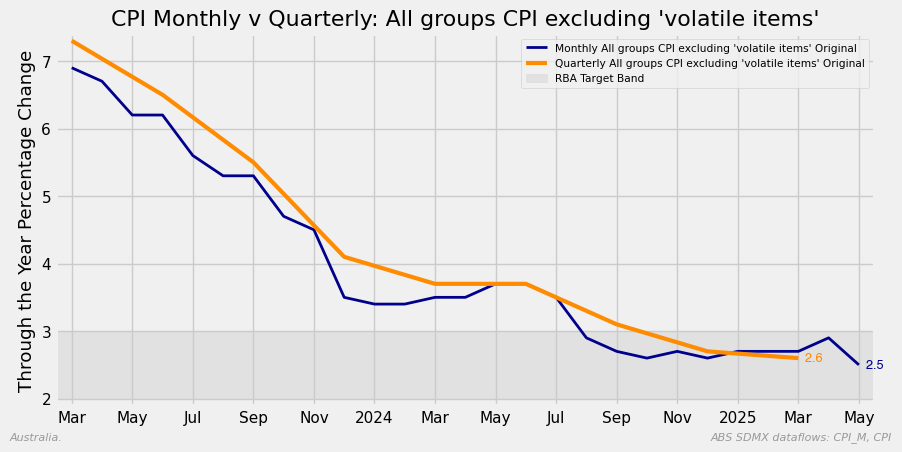

Processing: Tradables
Missing dimensions for CPI_M: ['TSEST']


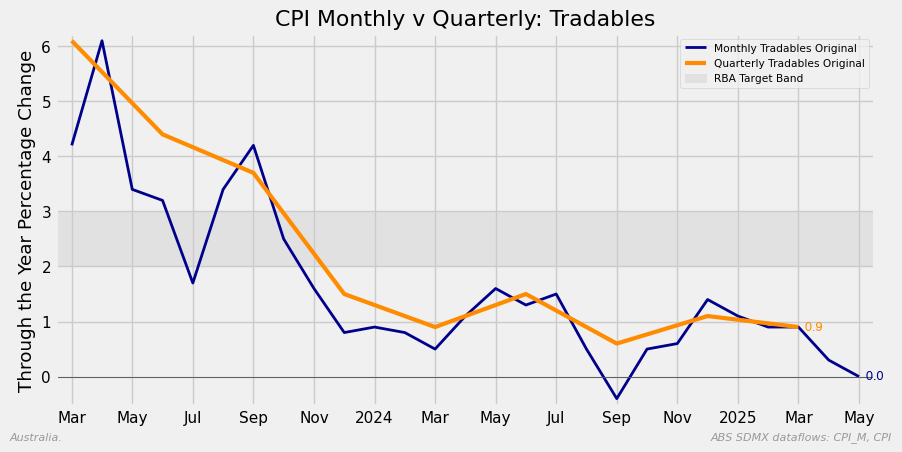

Processing: Non-tradables
Missing dimensions for CPI_M: ['TSEST']


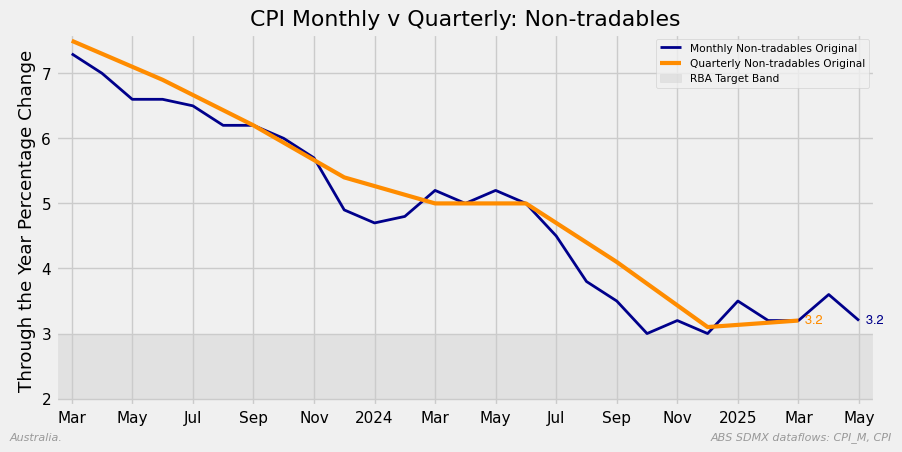

In [8]:
# CPI items for monthly vs quarterly comparison
CPI_COMPARISON_ITEMS = [
    "All groups CPI",
    "All groups CPI, seasonally adjusted",
    "All groups, services component",
    "All groups, goods component",
    "Trimmed Mean",
    "All groups CPI excluding 'volatile items'",
    "Tradables",
    "Non-tradables"
]

# Date range parameters
START_PARAMS = {
    "monthly": {"startPeriod": "2020-01"},
    "quarterly": {"startPeriod": "2020-Q1"}
}


def fetch_monthly_cpi_data(item: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Fetch monthly CPI data for a specific item."""
    # Handle special case for Trimmed Mean
    monthly_item = item if item != "Trimmed Mean" else "Annual trimmed mean"

    criteria = [
        sa.match_item(monthly_item, "INDEX", Mt.EXACT),
        sa.match_item("Monthly", "FREQ", Mt.PARTIAL),
        sa.match_item("Percentage Change from Corresponding", "MEASURE", Mt.PARTIAL),
        sa.match_item("Weighted average of eight capital cities", "REGION", Mt.EXACT),
    ]

    data, metadata = sa.fetch_selection("CPI_M", criteria, validate=True, parameters=START_PARAMS["monthly"])

    if len(data.columns) != 1:
        raise ValueError(f"Expected single column for monthly {item}, got {len(data.columns)}")

    return data, metadata


def fetch_quarterly_cpi_data(item: str, tsest: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Fetch quarterly CPI data for a specific item."""
    criteria = [
        sa.match_item(tsest, "TSEST", Mt.EXACT),
        sa.match_item(item, "INDEX", Mt.EXACT),
        sa.match_item("Quarterly", "FREQ", Mt.PARTIAL),
        sa.match_item("Weighted average of eight capital cities", "REGION", Mt.EXACT),
        sa.match_item("Percentage Change from Corresponding", "MEASURE", Mt.PARTIAL),
    ]

    data, metadata = sa.fetch_selection("CPI", criteria, validate=True, parameters=START_PARAMS["quarterly"])

    if len(data.columns) != 1:
        raise ValueError(f"Expected single column for quarterly {item}, got {len(data.columns)}")

    return data, metadata


def create_comparison_columns(
    item: str,
    monthly_item: str,
    monthly_data: pd.DataFrame,
    monthly_meta: pd.DataFrame,
    quarterly_data: pd.DataFrame,
    quarterly_meta: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Create properly named columns for comparison plotting."""
    # Get TSEST values and clean them if they're redundant with item name
    monthly_tsest = str(monthly_meta.loc[monthly_data.columns[0], "TSEST"])
    monthly_tsest = monthly_tsest if monthly_tsest.lower() not in item.lower() else ""

    quarterly_tsest = str(quarterly_meta.loc[quarterly_data.columns[0], "TSEST"])
    quarterly_tsest = quarterly_tsest if quarterly_tsest.lower() not in item.lower() else ""

    # Create column names
    monthly_name = (
        f"{monthly_meta.loc[monthly_data.columns[0], 'FREQ']} "
        + f"{monthly_item} {monthly_tsest}".strip()
    )
    quarterly_name = (
        f"{quarterly_meta.loc[quarterly_data.columns[0], 'FREQ']} "
        + f"{item} {quarterly_tsest}".strip()
    )

    # Rename columns
    monthly_data = monthly_data.copy()
    quarterly_data = quarterly_data.copy()
    monthly_data.columns = [monthly_name]
    quarterly_data.columns = [quarterly_name]

    return monthly_data, quarterly_data


def plot_monthly_vs_quarterly_item(item: str) -> None:
    """Plot monthly vs quarterly comparison for a single CPI item."""
    print(f"Processing: {item}")

    try:
        # Fetch monthly data
        monthly_data, monthly_meta = fetch_monthly_cpi_data(item)

        # Get TSEST for quarterly data (handle special case for Trimmed Mean)
        tsest = (
            str(monthly_meta.loc[monthly_data.columns[0], "TSEST"])
            if item != "Trimmed Mean" else "Seasonally adjusted"
        )

        # Fetch quarterly data
        quarterly_data, quarterly_meta = fetch_quarterly_cpi_data(item, tsest)

        # Convert quarterly to monthly periods
        quarterly_data.index = pd.PeriodIndex(quarterly_data.index).to_timestamp(how="end").to_period("M")

        # Get recent starting point
        recent_period = quarterly_data.index[-9]

        # Create properly named columns
        monthly_item = item if item != "Trimmed Mean" else "Annual trimmed mean"
        monthly_data, quarterly_data = create_comparison_columns(
            item, monthly_item, monthly_data, monthly_meta, quarterly_data, quarterly_meta
        )

        # Merge data
        combined_data = monthly_data.join(quarterly_data, how="left")

        # Plot comparison
        mg.line_plot_finalise(
            combined_data,
            plot_from=recent_period,
            title=f"CPI Monthly v Quarterly: {item}",
            ylabel="Through the Year Percentage Change",
            axhspan=RBA_TARGET_BAND,
            legend=True,
            y0=True,
            width=[2, 3],
            lfooter="Australia. ",
            rfooter="ABS SDMX dataflows: CPI_M, CPI",
            annotate=True,
            rounding=1,
            show=SHOW_CHARTS,
        )

    except Exception as e:
        print(f"Error processing {item}: {e}")


def monthly_vs_quarterly() -> None:
    """Compare monthly and quarterly CPI series for all items."""
    for item in CPI_COMPARISON_ITEMS:
        plot_monthly_vs_quarterly_item(item)


# Execute the comparison
monthly_vs_quarterly()

## Finished

In [9]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-07-16 10:29:47

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

typing : 3.10.0.0
pandas : 2.3.1
sdmxabs: 0.1.10a1
mgplot : 0.2.6

Watermark: 2.5.0



In [10]:
print("Finished")

Finished
